In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import regression_funs as rfu
import funs as fu
import geopandas

import matplotlib.gridspec as gridspec

from sklearn.linear_model import ElasticNetCV

import cartopy.crs as ccrs


# constants

In [2]:

# PATH_TO_FILE = '../data_in/flexpart-mosaic-data_alias/AIRTRACER_100m.nc'

# PATH_TO_SO2 = '../data_in/flexpart-mosaic-data_alias/MSAQSO2L4_2005-2018_v01-04_20190314.h5'

# PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

# PATH_TO_BC = '../data_in/black_carbon_channel6_masked_5min.csv'
# PATH_TO_BC = '../data_in/black_carbon_channel6_raw_5min.csv'


PATH_TO_ST = '../data_in/ciapitof_masked_filtered.csv'

PATH_200_CLUS = '../data_out/cluster1000.nc'

OUT_FILE = '../data_out2/20_clus_MSA_sources_inverse.csv'
OUT_DS_FILE = '../data_out2/DS_20__MSA_sources_inverse.nc'
OUT_CONTRS_FILE = '../data_out2/CONTRS_20__MSA_sources_inverse.csv'

OUT_MEAS_FILE = '../data_out2/MEAS_20__MSA_sources_inverse.csv'


LA = 'lat'
LO = 'lon'
AT = 'AIRTRACER'
L = 'lab'

SA = 'sa'
MSA = 'msa'
IA = 'ia'

BC = 'bc_masked_ngm3'
# BC = 'bc_raw_ngm3'

LBC = 'log(bc)'

LSA = 'log10(sa)'
LMSA = 'log10(msa)'
LIA = 'log10(ia)'

DATA_OUT = '../data_out'

In [3]:
PAR = MSA
#

# open and plot PAR timeseries

In [4]:
def _get_df():
    df = pd.read_csv(PATH_TO_ST, index_col=0, parse_dates=True)
    zeros = df[MSA] > 0
    print('zeros vs non zeros')
    print(zeros.value_counts())
    df = df[zeros]
    return df

df = _get_df()

zeros vs non zeros
True     27170
False      231
Name: msa, dtype: int64


In [5]:
df = df['2020-03':]

In [6]:
df[PAR].quantile([0,.999])

0.000    2.632481e+03
0.999    5.417409e+07
Name: msa, dtype: float64

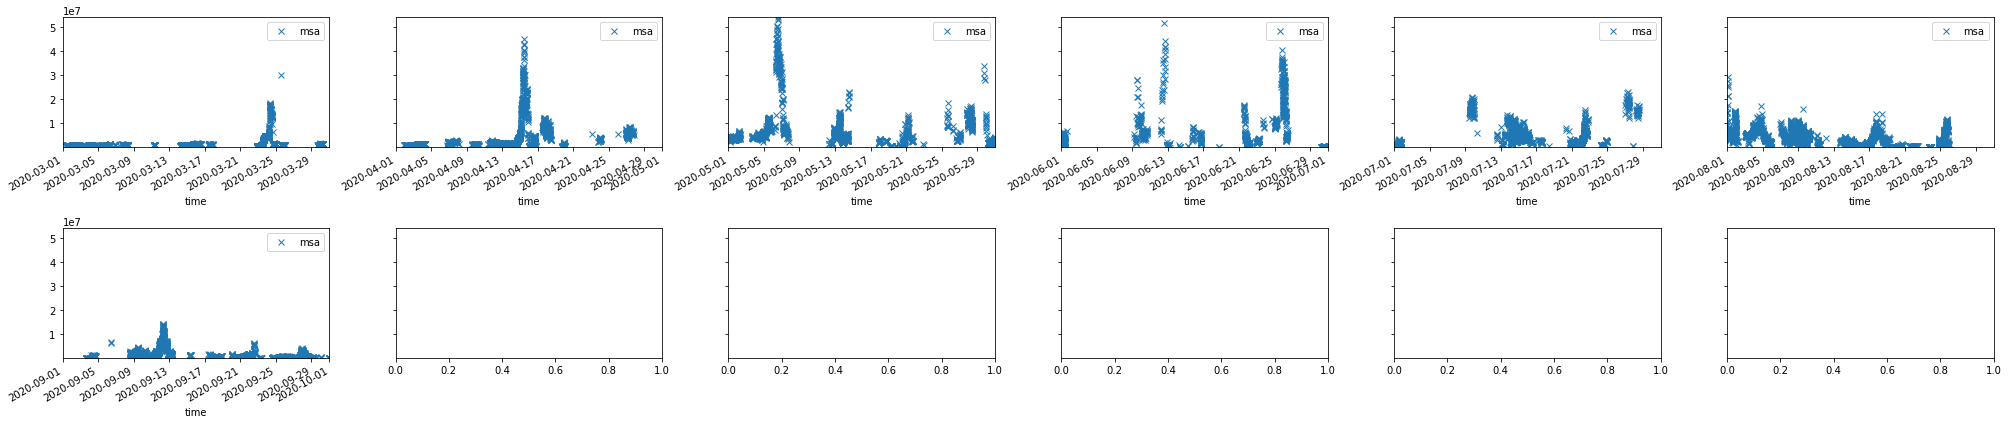

In [7]:
def plt_1(df,ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 5))
    df[[PAR]].plot(ax=ax, marker='x', lw=0)
    
def mplt(df):
    qm,qM = df[PAR].quantile([0,.999])
    f,axs = plt.subplots(2,6,sharey=True,figsize=(28,6))
    axf =axs.flatten()
    mm = df.index.min()
    mM = df.index.max()

    ms = [m.strftime('%Y-%m') for m in pd.date_range(mm, mM, freq='M')]
    for i,m in enumerate(ms):
        plt_1(df.loc[m],ax=axf[i])
        ax = axf[i]
        m_ = pd.to_datetime(m)+pd.Timedelta(30,'D')
#         print(m_)
        ax.set_xlim(pd.to_datetime(m), m_)
        ax.set_ylim(qm,qM)
#         ax.set_yscale('symlog',linthresh=1e5,linscale=.1)
#         ax.set_yticks([0,*[a*10**5 for a in range(1,10)],1e5,1e6,1e7])
    f.tight_layout()

mplt(df)

(0.0, 77923400.77593994)

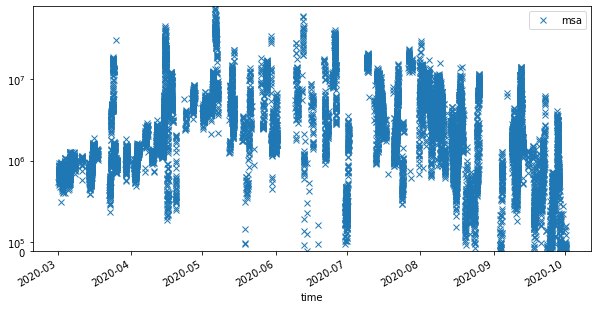

In [8]:
plt_1(df)
plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
plt.gca().set_ylim(0,None)

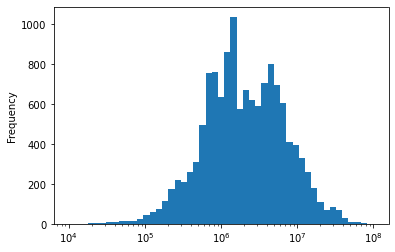

In [9]:
def _plt_dist(df):
    df[PAR].plot.hist(bins=np.geomspace(1e4, 1e8))
    plt.gca().set_xscale('log')
_plt_dist(df)

# open and merge flex 200 ro 1000 clusters

In [10]:
ds = xr.open_dataset(PATH_200_CLUS)

In [11]:
def _merge_ds_and_df(ds,df):
    dsf = ds.groupby(L).sum().to_dataframe()[AT].unstack(L)

    df1 = df

    df2 = df1.resample('3H').median()

    dm = pd.merge(df2, dsf, left_index=True, right_index=True, how='inner', validate="1:1")
    return dm,dsf 
dm,dsf = _merge_ds_and_df(ds,df)

# 1st CV Inverse modeling elastic NET

4350.513543373454 1.0


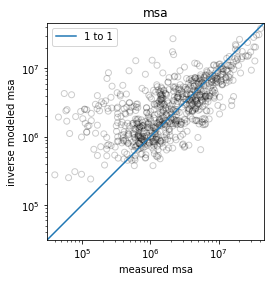

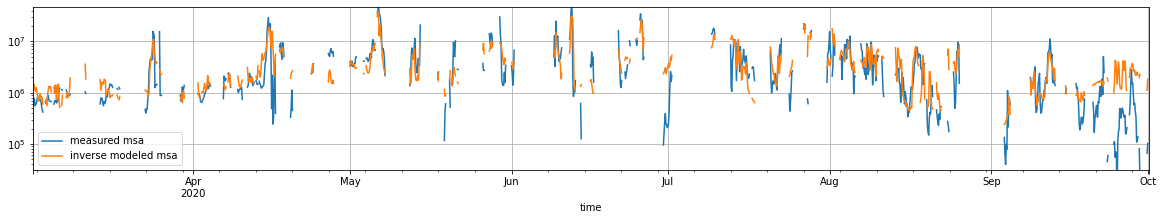

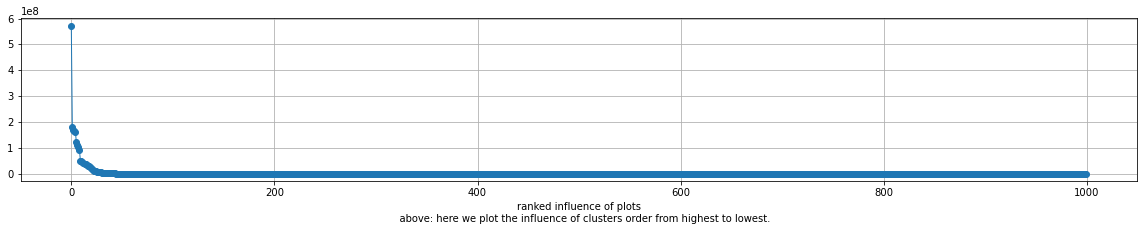

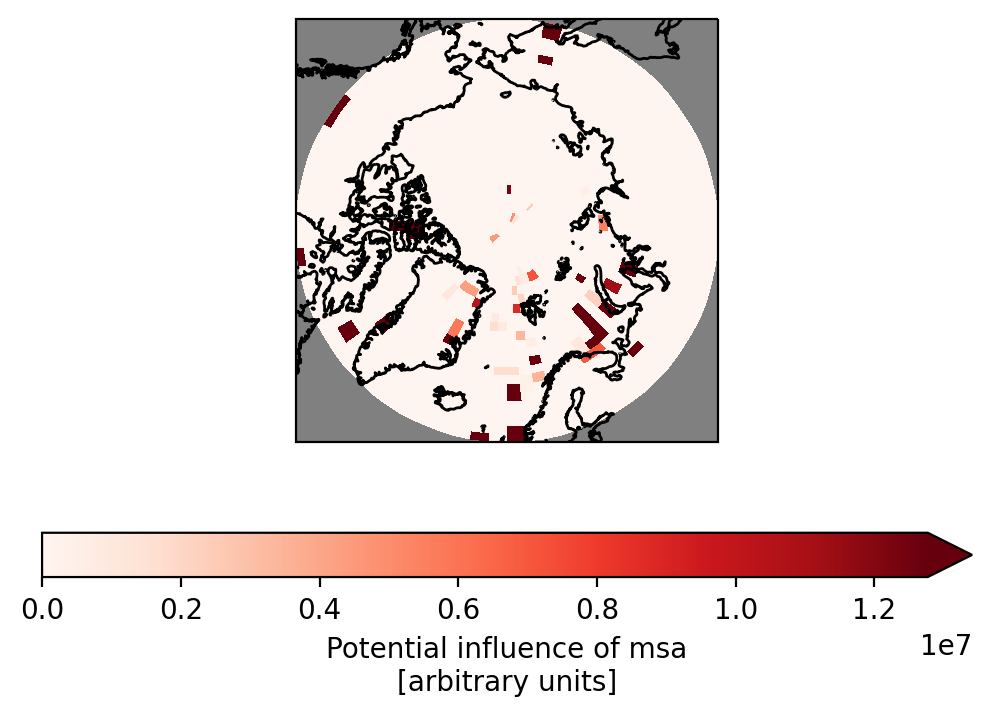

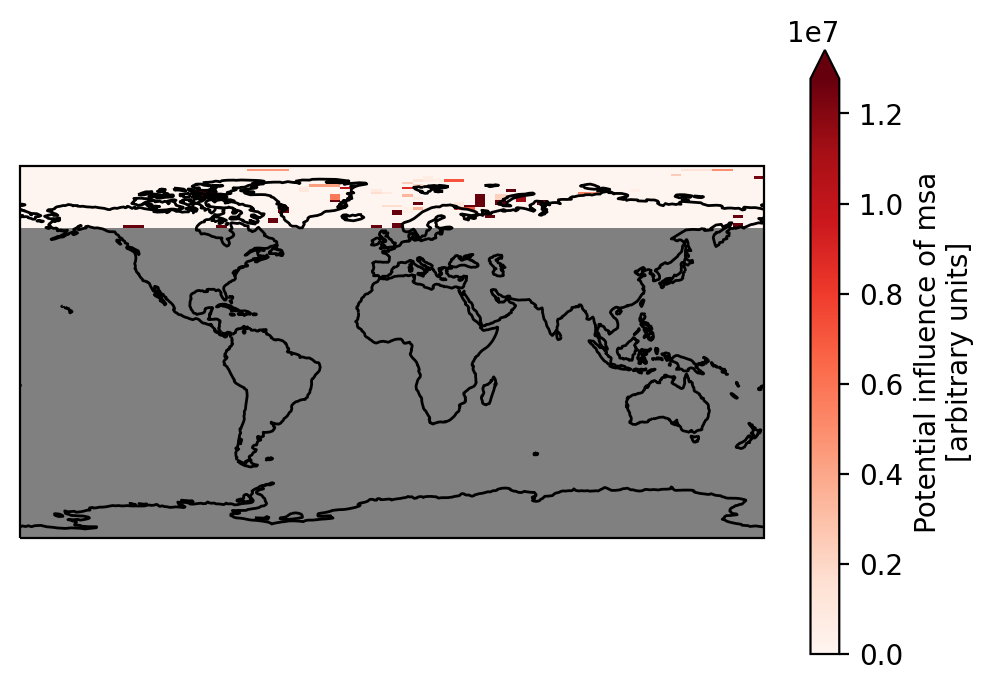

In [12]:
# for PAR in [SA,MSA,IA]:
def plt_el_net(dsf,dm):
    pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp, pred, MEA, MOD)
    rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net(dsf,dm)

In [13]:
pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

4350.513543373454 1.0


In [14]:
def get_rat(dp,y,yn):
    from sklearn.linear_model import LinearRegression

    lr = LinearRegression(fit_intercept=True).fit(dp[yn].to_frame(),y[yn])
    
    r2 = lr.score(dp[yn].to_frame(),y[yn])
    coef = lr.coef_.item()
    inte = lr.intercept_

    return r2,coef, inte
r2, rat,inte = get_rat(dp,y,yn)
rat, r2,inte

(1.1102358102798462, 0.6838994750877042, -313162.25)

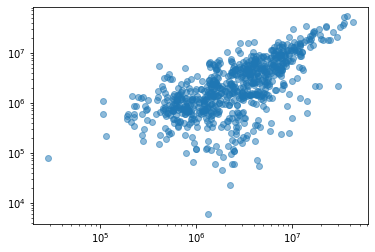

In [15]:
plt.scatter(dp[yn]*rat+inte,y[yn],alpha=.5)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

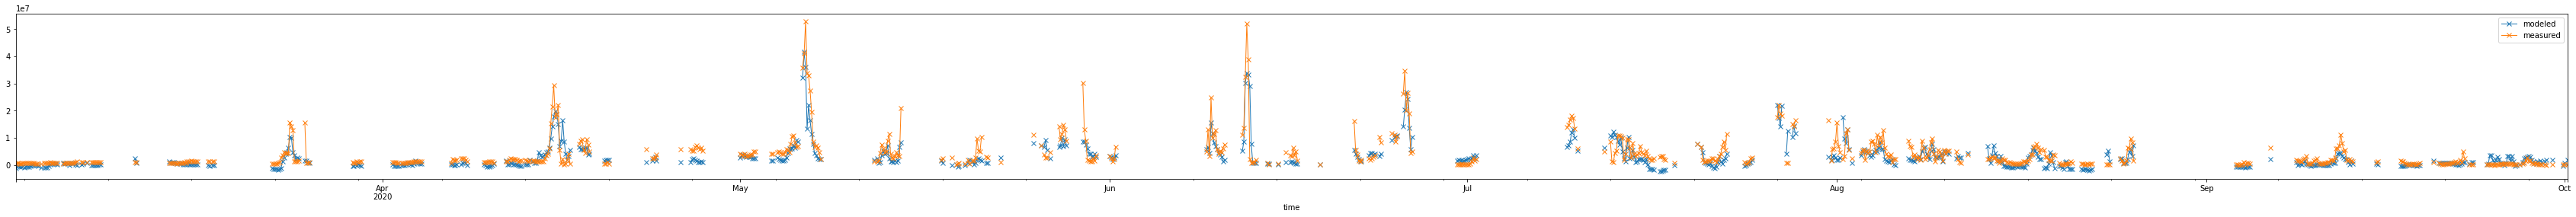

In [16]:
def _plot(rat,dm,dsf,cdf,y, inte):
    # AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf*rat+inte))
    __ = _.sum(axis=1)[yn].resample('3H').mean()
    __.plot(lw=1,marker='x', label = 'modeled')
    plt.gcf().set_figwidth(60)
#     plt.gca().set_yscale('symlog',linthresh=1e5,linscale=.1)
#     plt.gca().set_ylim(0,None)
    y[yn].resample('3H').mean().plot(lw=1,marker='x', label = 'measured')
    plt.gca().legend()

_plot(rat,dm,dsf,cdf,y,inte)

In [17]:
def get_contr(rat,dm,dsf,cdf,A,yn,inte):
    _cdf = cdf>0
#     AA = rat #should be 1
    _ = (dm[dsf.columns] * (cdf * rat+inte))[yn].T.where(_cdf).T
    __ = _.sum(axis=0)
    a =  __.sort_values()[::-1].cumsum()/__.sum()
    __ = __.where(a<A,0)
    return __

contr =  get_contr(rat,dm,dsf,cdf,1,yn,inte)

In [18]:
contr

0      113044984.0
1              0.0
2        6301465.0
3              0.0
4              0.0
          ...     
995            0.0
996            0.0
997            0.0
998            0.0
999            0.0
Length: 1000, dtype: float32

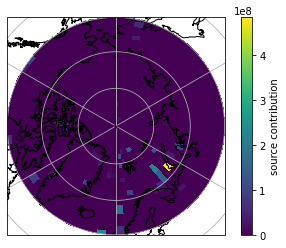

In [19]:
def _plt(ds,contr,ax=None):
    import matplotlib as mpl
    # pred, cdf, y, yn, dp, regr = rfu.elastic_net_reg2(dsf, dm, PAR)

    _1 = ds['lab'].to_dataframe()['lab'].iloc[:, 1].replace(contr.to_dict()).to_xarray()
    _1.name = 'source contribution'

    if ax is None:
        _, ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    _1.plot(ax=ax, transform=ccrs.PlateCarree(),vmin=0)


_plt(ds,contr)

In [20]:
N=13

def _clus(dm,dsf,cdf,contr,ds,yn,rat,inte, N ):
#     N = 20

    from sklearn.cluster import KMeans

    contrs_ = (dm[dsf.columns] * (cdf*rat + inte)).T.where(contr > 0, 0).T[yn]

    _norm = np.sqrt((contrs_ ** 2).sum())

    _nn = contrs_ / _norm
    _nn1 = _nn.dropna(axis=1)

    km = KMeans(N, random_state=123)

    _l = km.fit_predict(_nn1.T.values) + 1

    _l1 = pd.Series(_l, index=_nn1.T.index)
    _nl = (_norm * 0 + _l1)

    def _reorder_by_inf(_nl, contrs_):
        i_ = contrs_.T.groupby(_nl).sum().T.sum().sort_values()[::-1].reset_index()['index']
        i_.index = i_.index + 1
        _order = {v: i for i, v in i_.items()}
        _nl = _nl.replace(_order)
        return _nl

    _nl = _reorder_by_inf(_nl, contrs_)

    d_ = ds['lab'].to_series().replace(_nl.to_dict()).to_xarray()
    d_.name = 'sorted_inf_clusters'
    return d_, contrs_, _nl


(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds,yn,rat,inte,N)





In [21]:
a = regr.alpha_
l = regr.l1_ratio_

In [22]:
a,l

(4350.513543373454, 1.0)

In [23]:
def _plot_clust_infs(contrs,nl,dsf,cdf,y, rat,dm,inte,yn,N):
    AA = 1
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    for i in range(1, N+1):
        (AA*clus_ts[i]).plot(c=plt.get_cmap('tab20')(i - 1),lw=5)
    plt.gcf().set_figwidth(60)
    plt.gca().legend()
    #plt.gca().set_yscale('symlog')

    #(contrs.T.groupby(nl).sum().sum()*rat).plot(c='.7', ls='--', marker='D')

    def plt_model(dm):
        _ = dm[dsf.columns] * (cdf * rat + inte)
        __ = _.sum(axis=1)
        __[yn].resample('3H').mean().plot(lw=1, marker='+', label='modeled', alpha=.5, c='k')

    plt_model(dm)

    y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5)

    plt.legend()
    ymin, ymax = y[yn].quantile([0,.999])
#     plt.gca().set_ylim(ymin,ymax)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33312/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


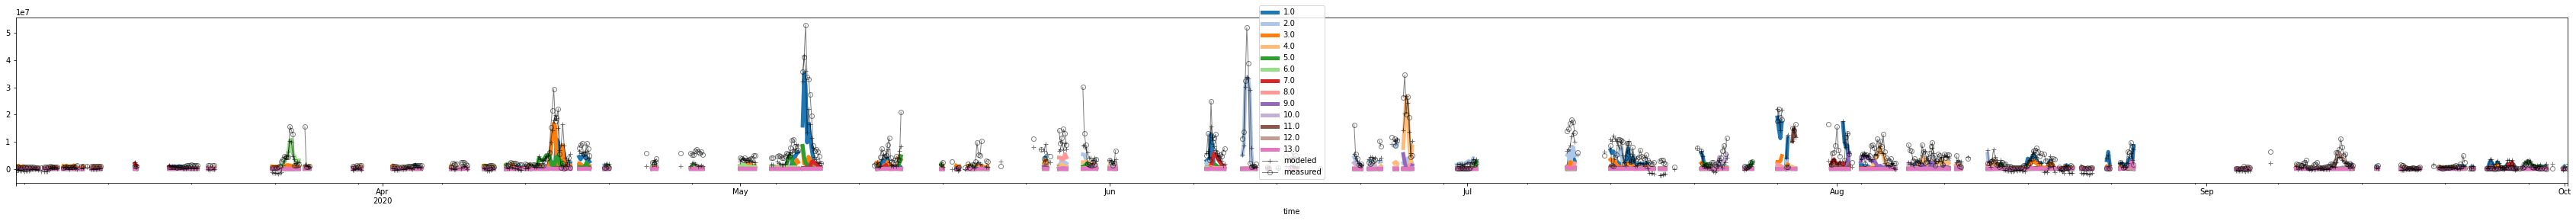

In [24]:
_plot_clust_infs(contrs,nl,dsf,cdf,y, rat, dm,inte,yn,N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33312/1956761208.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


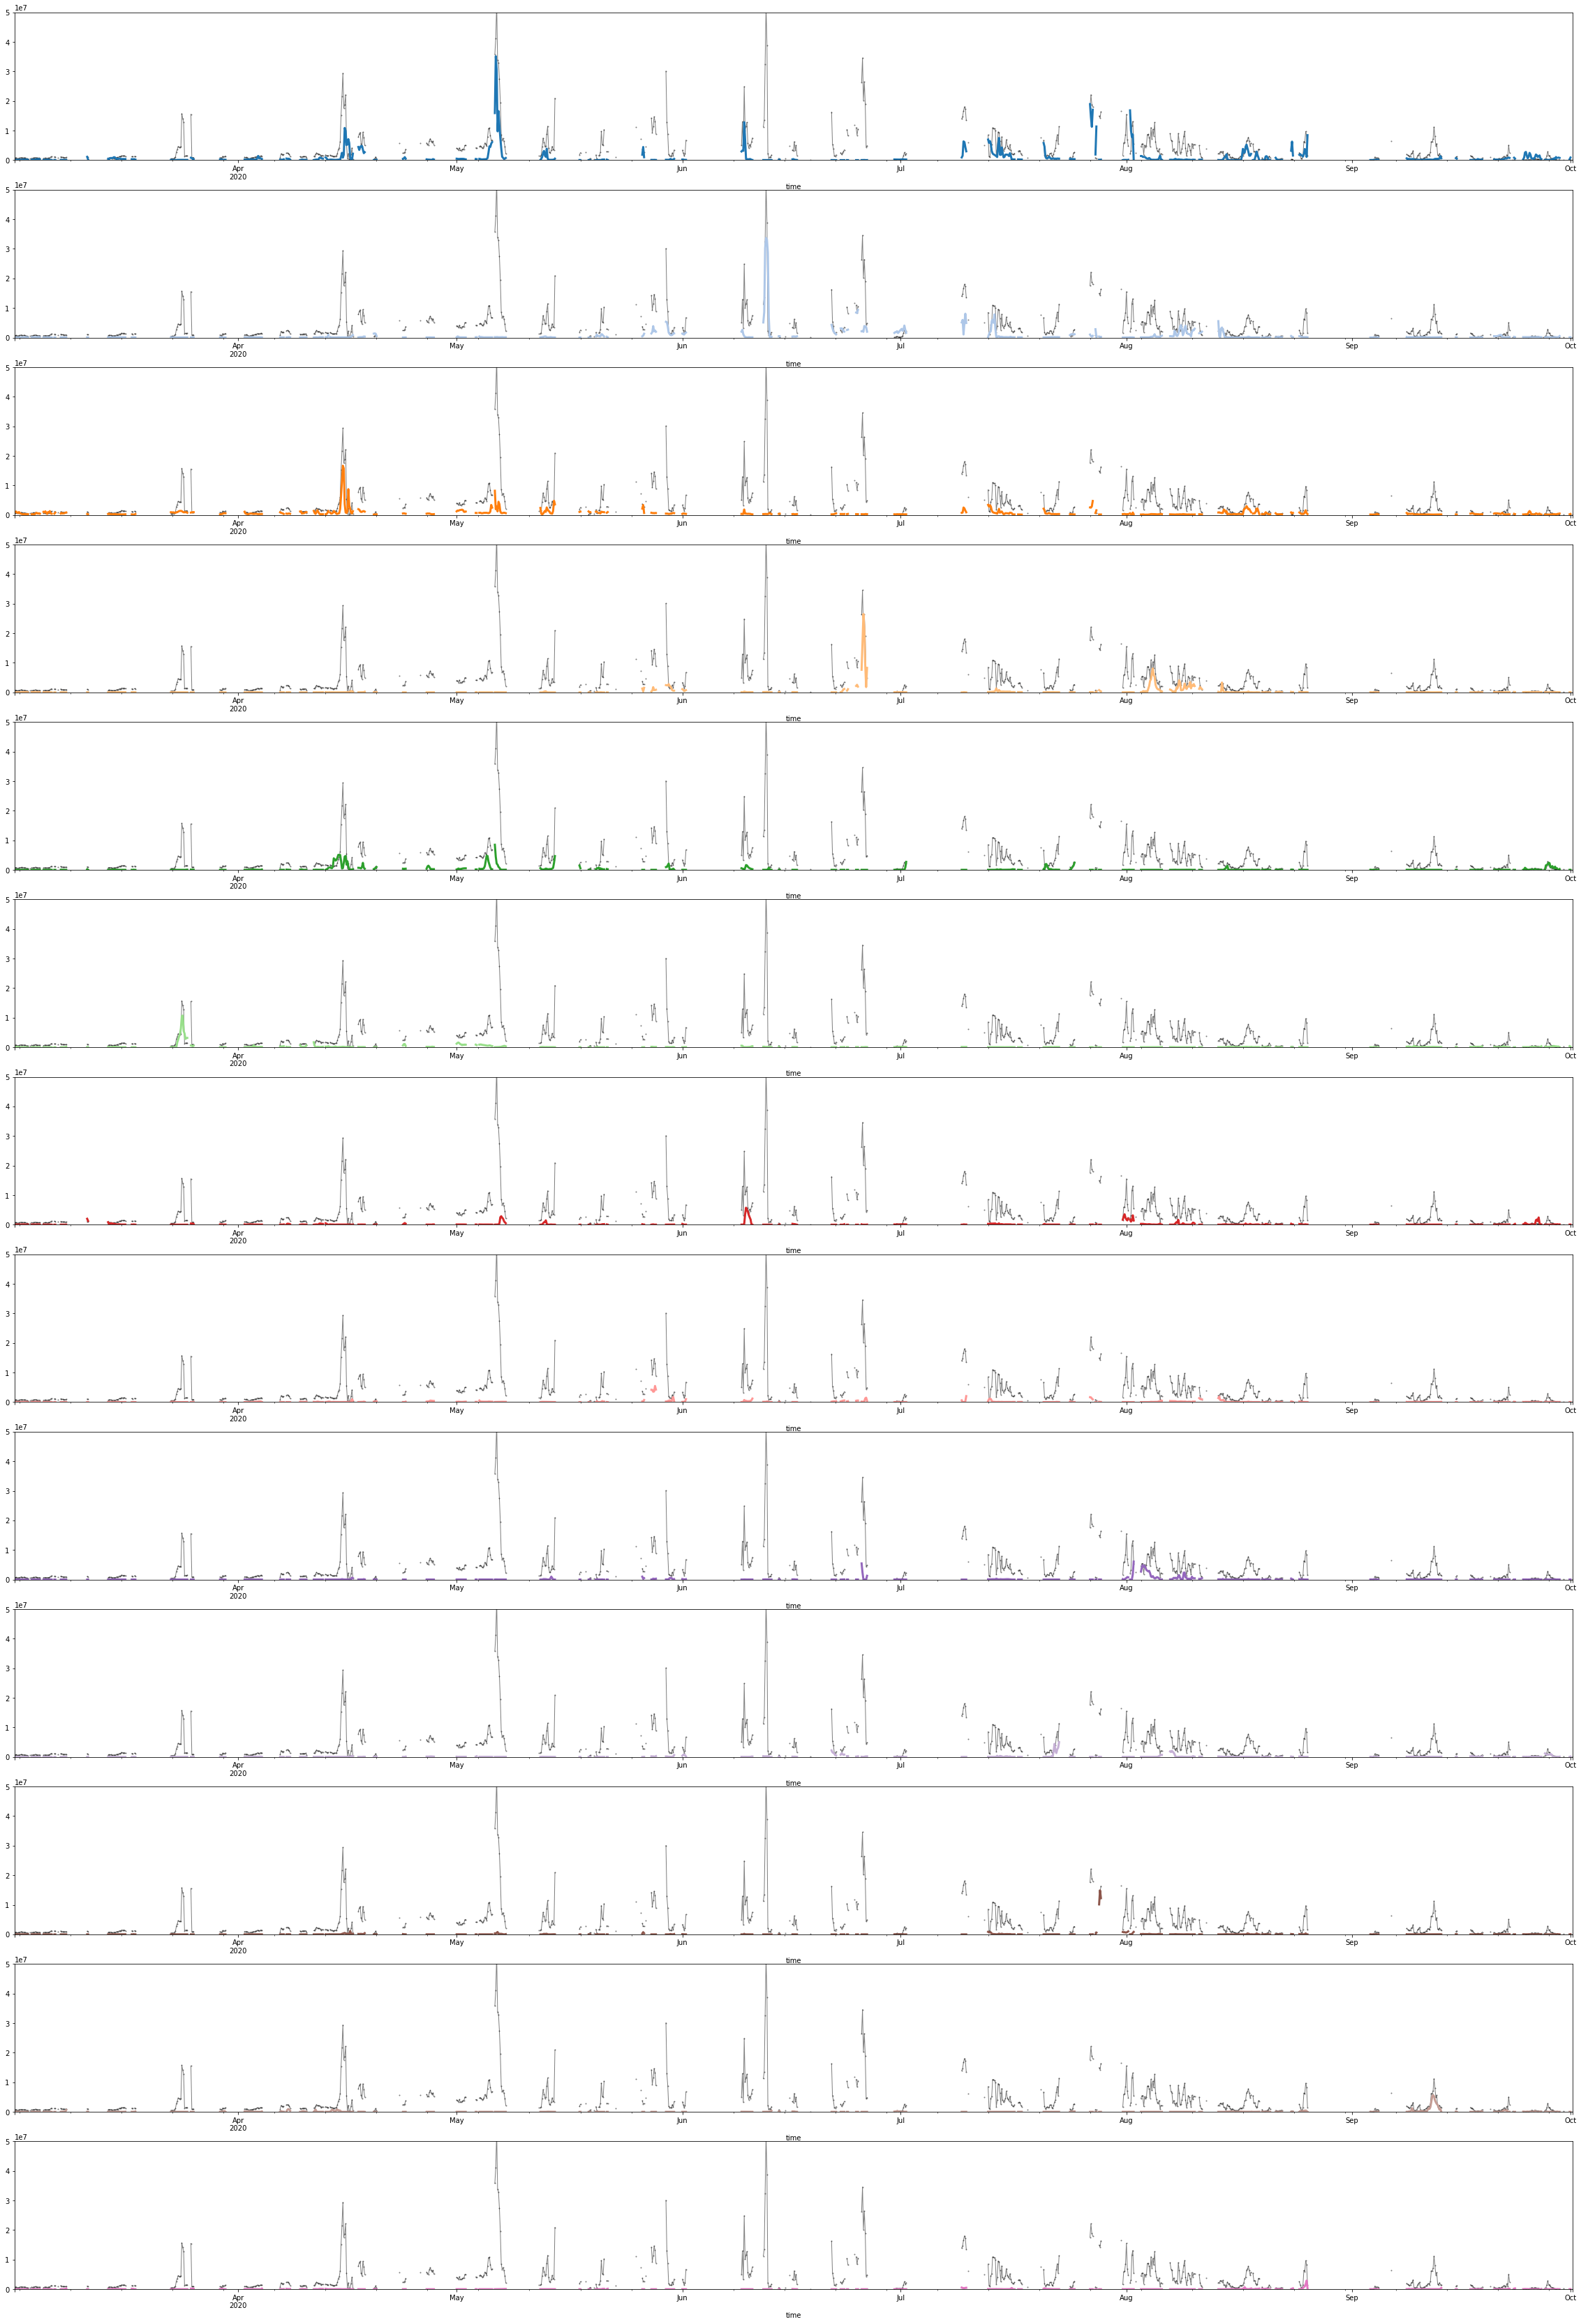

In [25]:
def plot_single_contrs(contrs, nl, yn,y, N):
    clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()
    f, axs = plt.subplots(N, 1, figsize=(40, 3 * 20), sharey=True)
    axf = axs.flatten()
    for i in range(1, N+1):
        y[yn].resample('3H').mean().plot(lw=1, marker='o', label='measured', c='k', mfc='none', alpha=.5, ax=axf[i - 1],
                                         ms=1)
        clus_ts[i].plot(ax=axf[i - 1], c=plt.get_cmap('tab20')(i - 1), lw=3)
        axf[i - 1].set_ylim(0, 5e7)

plot_single_contrs(contrs, nl, yn,y, N)

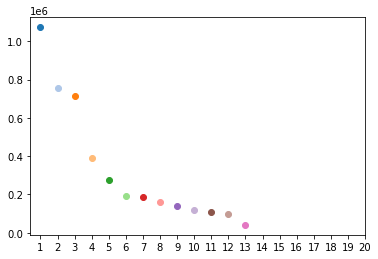

In [26]:
def plt_contrs(contrs,nl,N):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,N):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl,N)

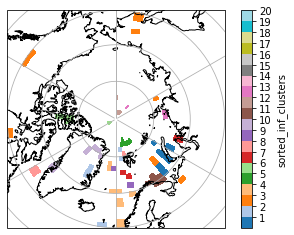

In [27]:
def _plt_influence_clusters(ds):
    import matplotlib as mpl
    _,ax = plt.subplots(subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    ax.coastlines()
    ax.gridlines()
    (ds['sorted_inf_clusters']-.5).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='tab20',
                                        cbar_kwargs={'ticks':range(1,21)},
                                        vmin=0,vmax=20)
_plt_influence_clusters(ds)

# multi elastic net

In [28]:
l

1.0

In [29]:
aa = np.geomspace(a/10,a*200,36)
CC = 25

LL = .5

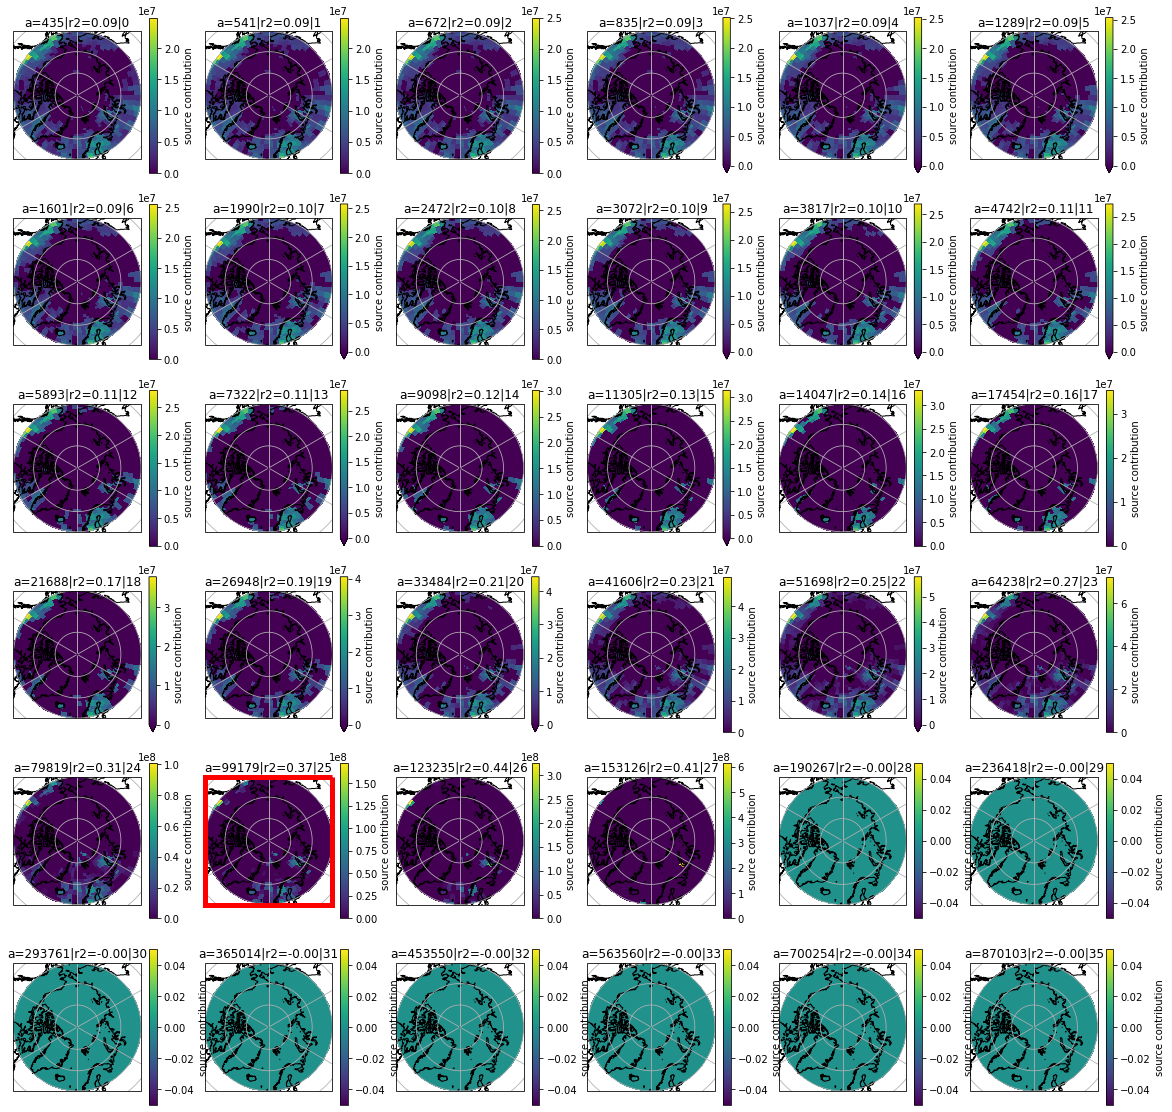

In [30]:
def elastic_net_reg3(dsf, dm, PAR, a, l ):
    from sklearn.linear_model import ElasticNet

    c200 = dsf.columns

    X = dm[c200]

    ### normalize X
    xn = np.sqrt(  (X ** 2).sum()  ) ** (1/1)
    XX = X.divide(xn, axis=1)
    #############


    _y = dm[PAR]
    yn = _y.notna()
    y = _y[yn]
    regr = ElasticNet(a,l1_ratio=l, random_state=123, positive=True, fit_intercept=False)

    regr.fit(XX[yn], y[yn])

#     print(regr.alpha_,regr.l1_ratio_)

    pred = regr.predict(XX[yn])
    dp = pd.Series(pred, index=y[yn].index)
    _cdf = pd.Series(regr.coef_, index=XX.columns)
    cdf = _cdf / xn
    return pred, cdf, y, yn, dp, regr

def _multi_plot(aa,CC):
    
    f,axs = plt.subplots(6,6,figsize=(20,20),subplot_kw=dict(projection=ccrs.Orthographic(0, 90)))
    axf = axs.flatten()
    
    for i_,a_ in enumerate(aa):
        ax = axf[i_]
        pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,a_,LL)
        r2, rat, inte = get_rat(dp,y,yn)
        contr = get_contr(rat,dm,dsf,cdf,1,yn,inte)
        _plt(ds,contr,ax)
        ax.set_title(f'a={a_:.0f}|r2={r2:.2f}|{i_}')
        if i_ == CC:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(5)
_multi_plot(aa,CC)

# chosen elastic net

In [31]:
pred, cdf, y, yn, dp, regr = elastic_net_reg3(dsf, dm, PAR,aa[CC],LL)
r2, rat, inte = get_rat(dp,y,yn)

In [32]:
LL,aa[CC]

(0.5, 99178.855722854)

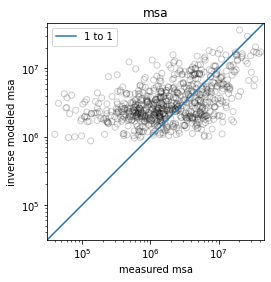

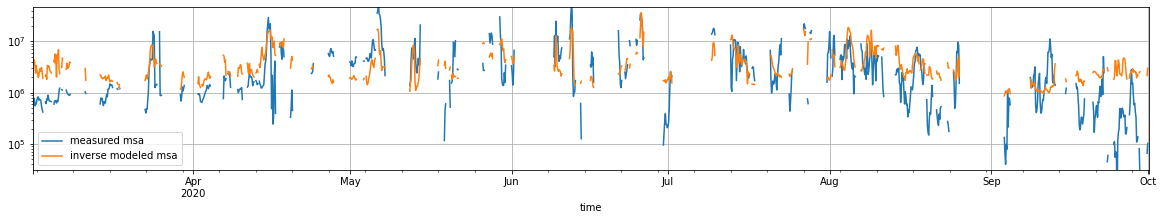

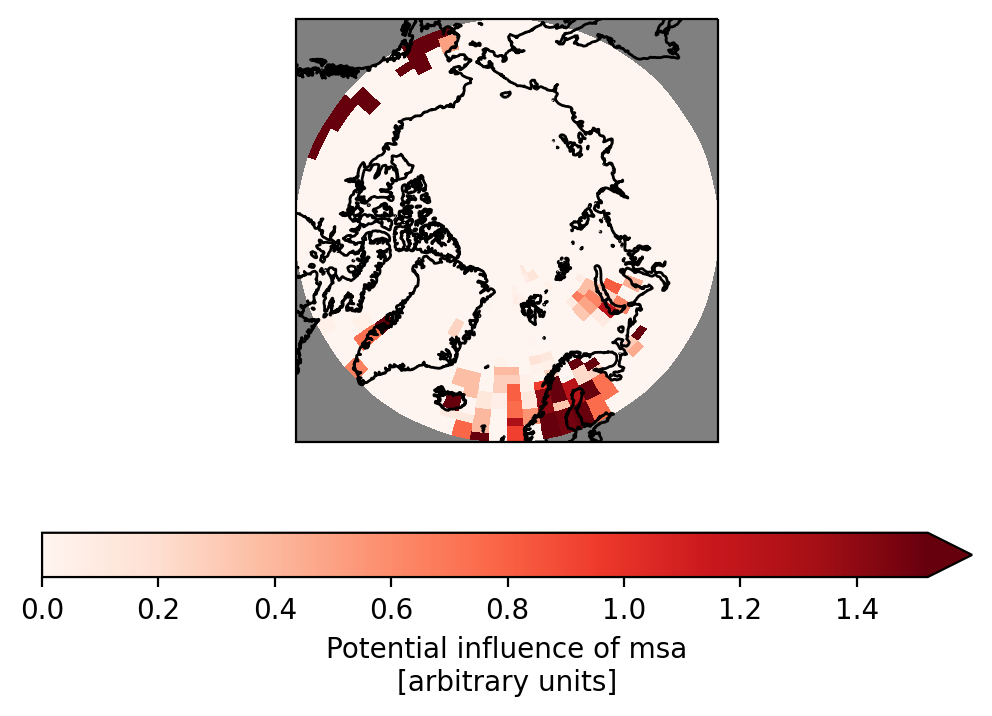

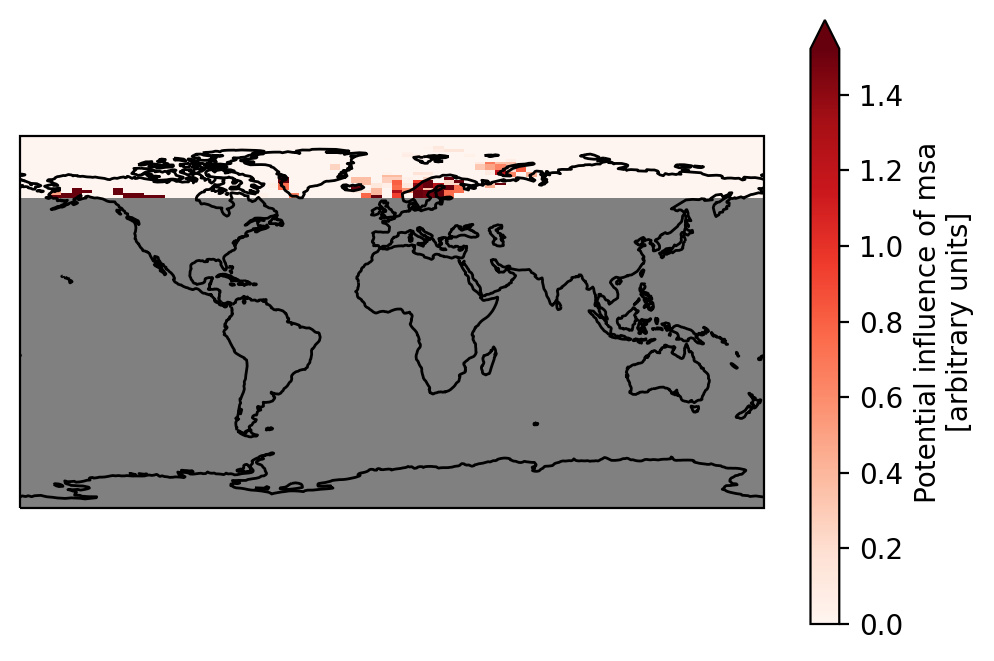

In [33]:
# for PAR in [SA,MSA,IA]:
def plt_el_net():
    
    MEA = f'measured {PAR}'
    MOD = f'inverse modeled {PAR}'
    rfu.scatter_plot(y, yn, pred*rat+inte, MEA, MOD, PAR)
    rfu.mea_vs_mod_plot(y, yn, dp*rat+inte, pred*rat+inte, MEA, MOD)
    #rfu.rank_cluster_inf(cdf)
    dd2 = rfu.get_plot_inf(cdf, L, ds, PAR)
    rfu.plot_map(dd2)
    rfu.plot_map_rect(dd2)
    return regr

    
regr = plt_el_net()

In [34]:
N = 20 
contr = get_contr(rat,dm,dsf,cdf,1, yn,inte)

(
    ds['sorted_inf_clusters'],
    contrs,
    nl
) = _clus(dm,dsf,cdf,contr,ds, yn, rat , inte, N)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33312/2105437306.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


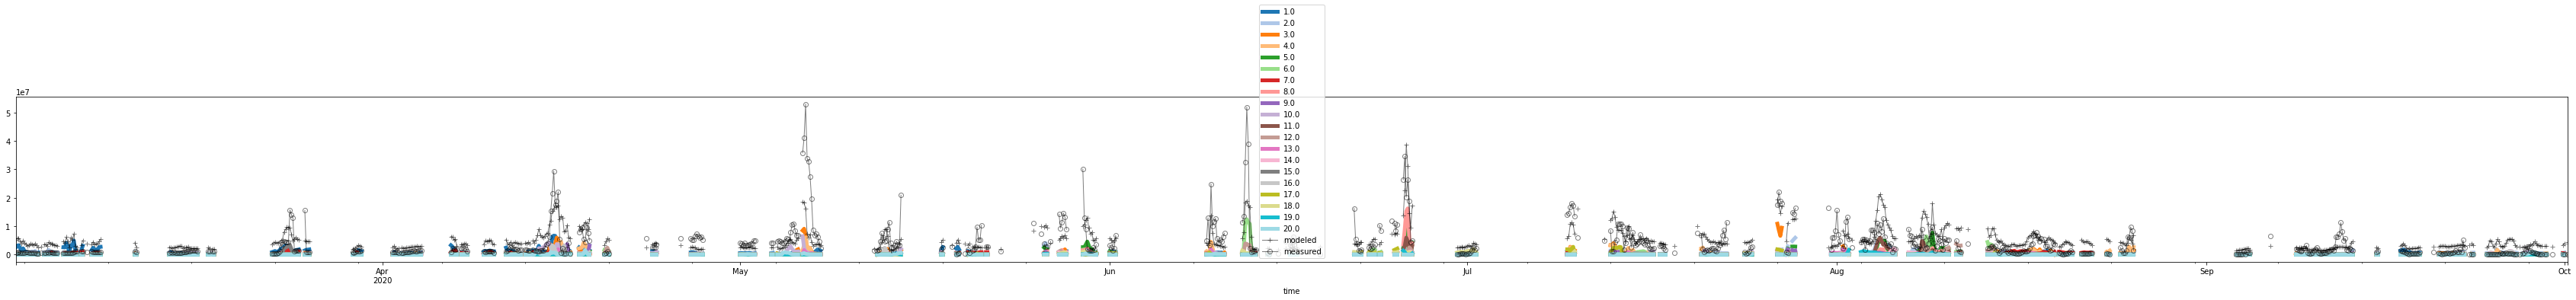

In [35]:
_plot_clust_infs(contrs=contrs,nl=nl,dsf=dsf,cdf=cdf,y=y, rat=rat, dm=dm, inte=inte, yn=yn,N=N)

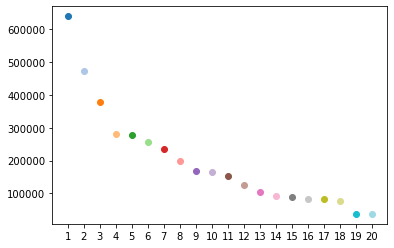

In [36]:
def plt_contrs(contrs,nl):
    d = contrs.T.groupby(nl).sum().T.mean()
    for i in range(0,20):
        plt.scatter(d.index[i],d.iloc[i],c=[plt.get_cmap('tab20')(i)])
    plt.gca().set_xticks(range(1,21));
plt_contrs(contrs,nl)

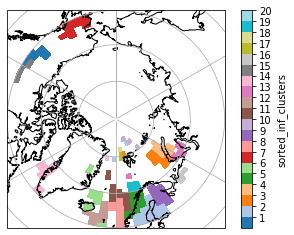

In [37]:
_plt_influence_clusters(ds)

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33312/1956761208.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


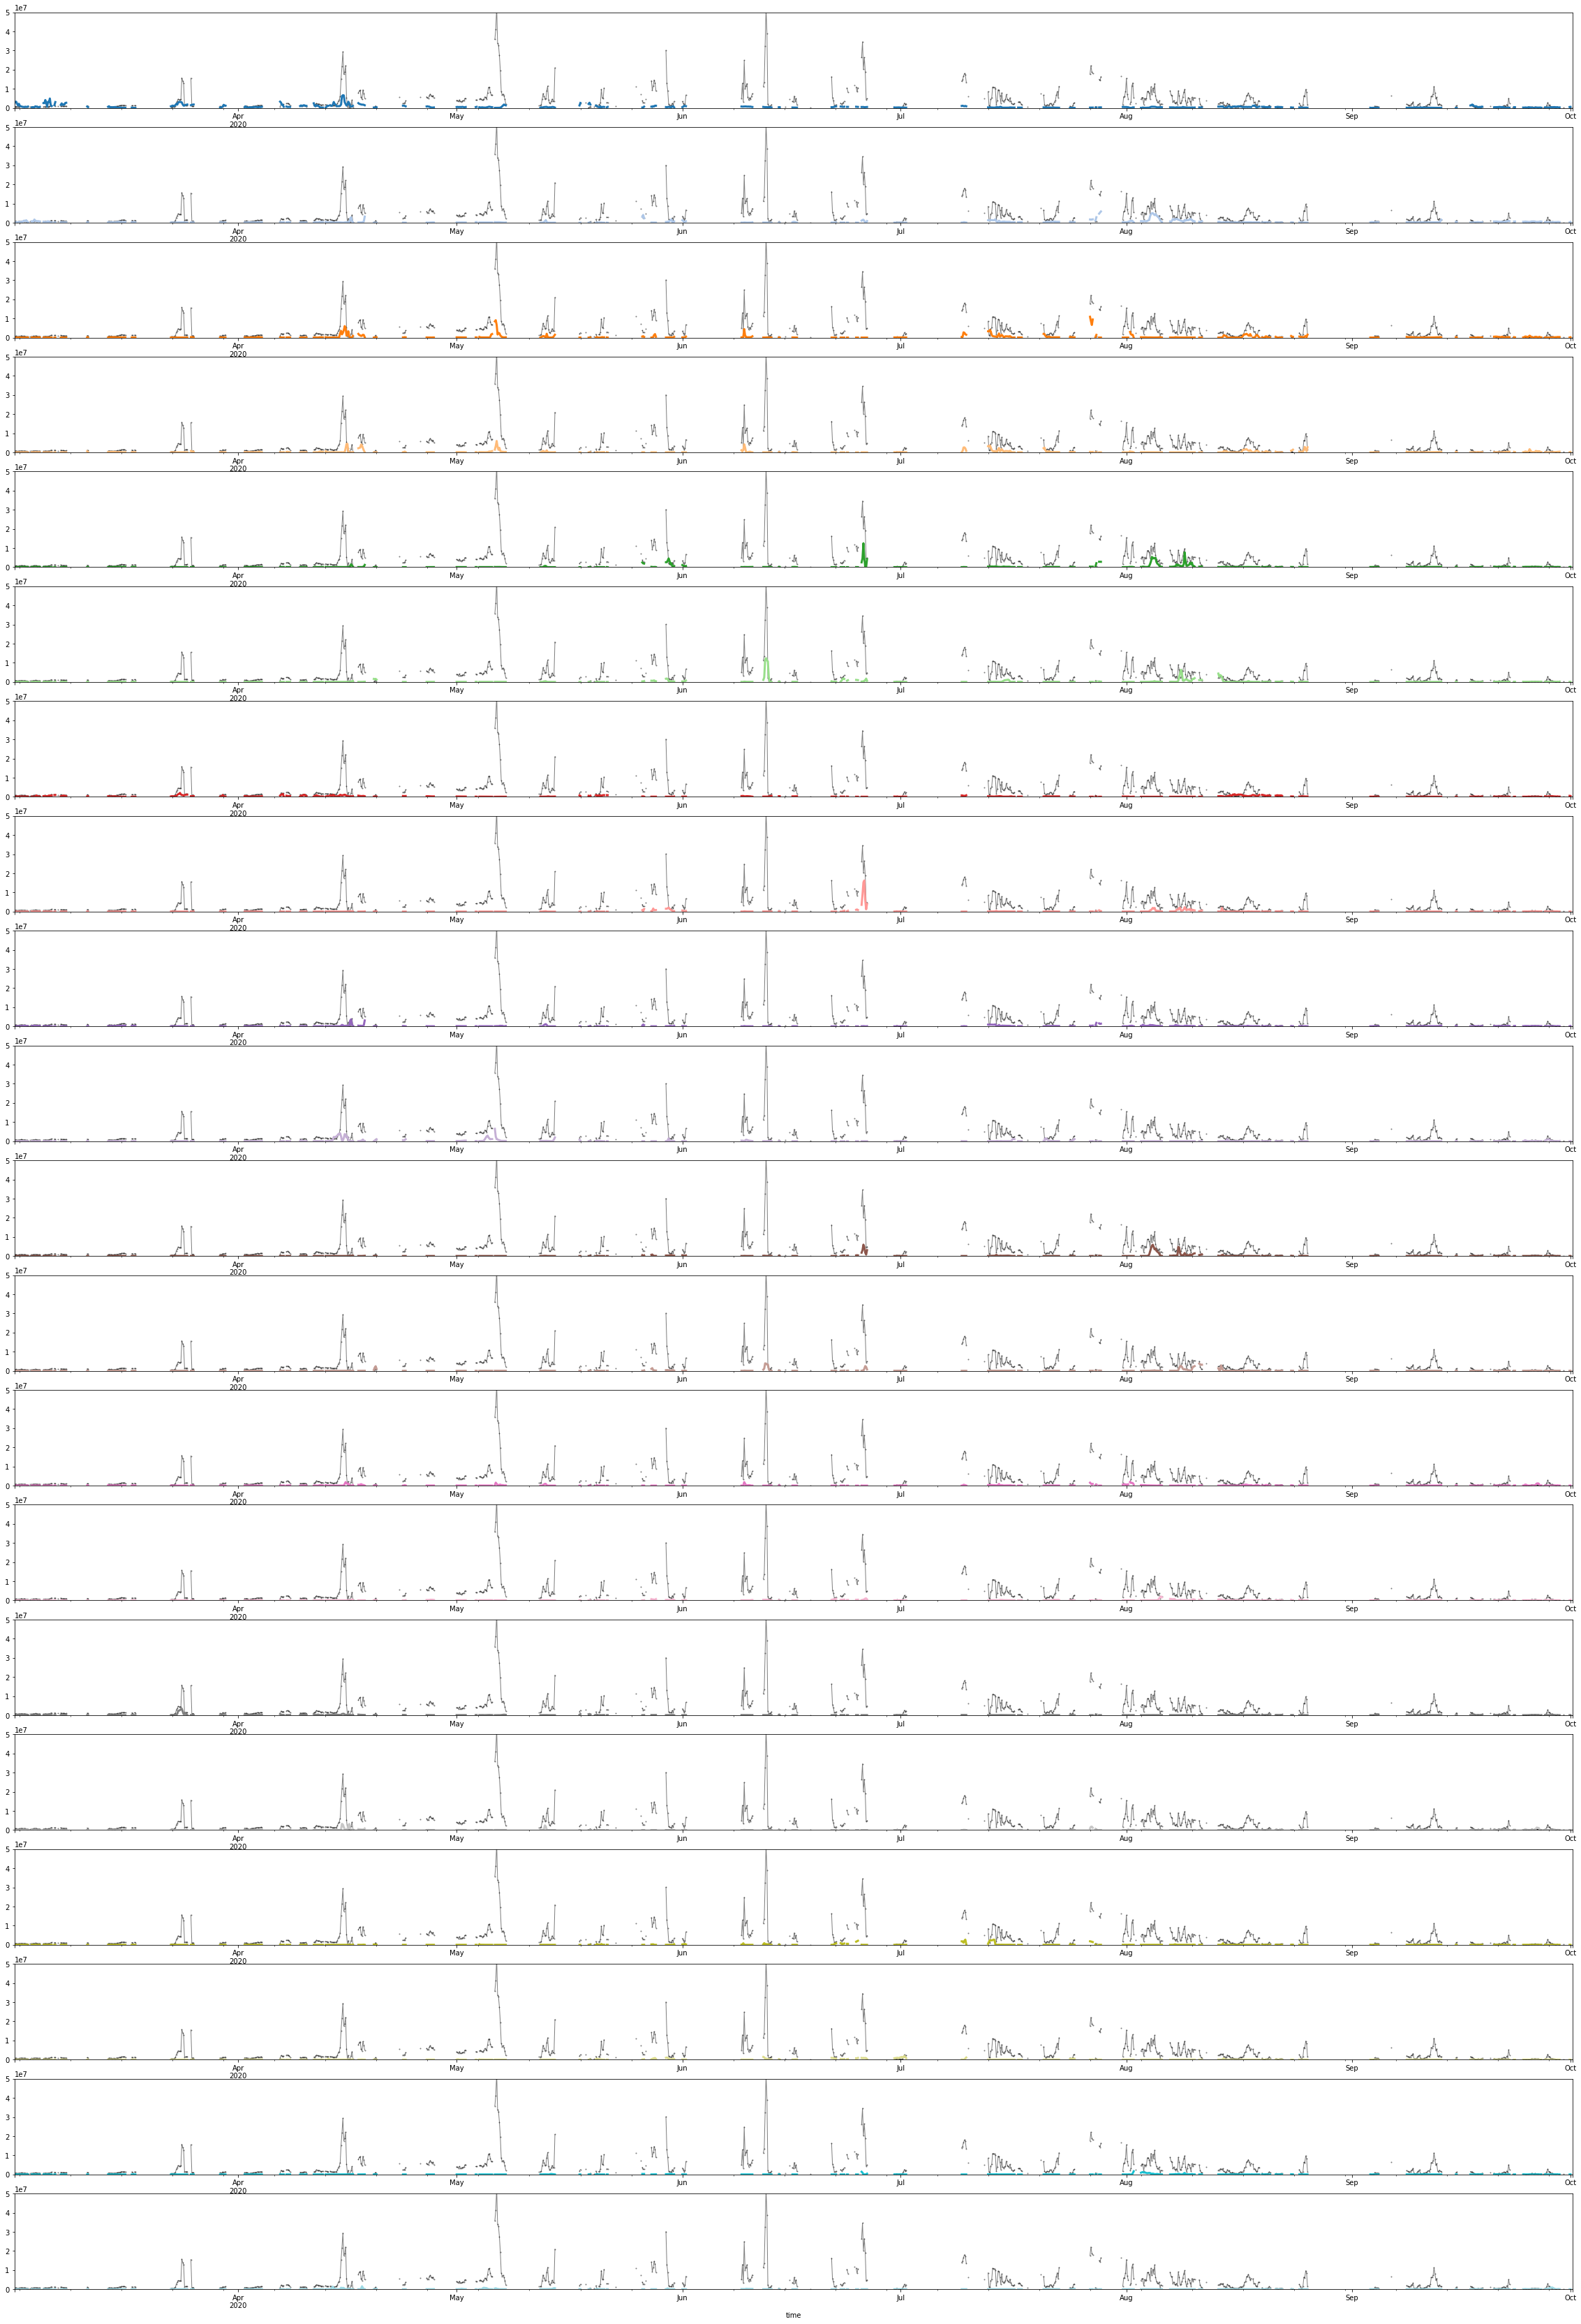

In [38]:
plot_single_contrs(contrs, nl, yn,y,N)

# save data

In [39]:
clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()

/var/folders/xl/wx70j1c50bsdzdy63_wpbhrxpglmw2/T/ipykernel_33312/2478368837.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clus_ts = contrs.T.groupby(nl).sum().T[yn].resample('3H').mean()


In [40]:
clus_ts

1.0            2.0            3.0   \
time                                                              
2020-03-01 06:00:00  2.414810e+06  225392.921875   21388.212891   
2020-03-01 09:00:00  3.148384e+06  223052.375000   22006.410156   
2020-03-01 12:00:00  3.285122e+06  220790.515625   20379.943359   
2020-03-01 15:00:00  2.187050e+06  232051.453125   22331.453125   
2020-03-01 18:00:00  1.272959e+06  334591.156250   29327.457031   
...                           ...            ...            ...   
2020-09-30 18:00:00           NaN            NaN            NaN   
2020-09-30 21:00:00  5.056619e+05  264990.500000   81679.171875   
2020-10-01 00:00:00  5.719591e+05  447634.687500  187050.765625   
2020-10-01 03:00:00           NaN            NaN            NaN   
2020-10-01 06:00:00  3.877307e+05  627183.250000  322809.343750   

                              4.0            5.0           6.0   \
time                                                              
2020-03-01 06:00:00   24590.472656   51850.476562  18729.039062   
2020-03-01 09:00:00   21962.318359   49641.843750  24250.242188   
2020-03-01 12:00:00   22606.439453   49846.785156  21221.865234   
2020-03-01 15:00:00   23356.755859   51269.519531  22259.355469   
2020-03-01 18:00:00   27475.847656   67245.656250  27020.666016   
...                            ...            ...           ...   
2020-09-30 18:00:00            NaN            NaN           NaN   
2020-09-30 21:00:00   82872.359375   76635.484375  55734.679688   
2020-10-01 00:00:00  224761.765625  131501.937500  73527.312500   
2020-10-01 03:00:00            NaN            NaN           NaN   
2020-10-01 06:00:00  387516.312500  251461.671875  96423.796875   

                              7.0           8.0            9.0          10.0  \
time                                                                           
2020-03-01 06:00:00  139514.406250  21964.046875   74384.710938  1250.292114   
2020-03-01 09:00:00  136708.640625  24478.939453   72778.492188  1138.005127   
2020-03-01 12:00:00  142938.375000  24374.824219   64715.761719  1036.726440   
2020-03-01 15:00:00  119839.320312  25014.203125   70199.335938   933.235840   
2020-03-01 18:00:00   96322.882812  32397.642578   93158.164062   905.557190   
...                            ...           ...            ...          ...   
2020-09-30 18:00:00            NaN           NaN            NaN          NaN   
2020-09-30 21:00:00  488005.843750  36483.148438   89859.140625  3892.953125   
2020-10-01 00:00:00  418955.687500  56348.542969  212628.187500  4762.954102   
2020-10-01 03:00:00            NaN           NaN            NaN          NaN   
2020-10-01 06:00:00  277358.093750  84714.507812  451007.406250  5145.517578   

                             11.0          12.0          13.0           14.0  \
time                                                                           
2020-03-01 06:00:00   7271.139648   7549.251953  30856.660156   13004.307617   
2020-03-01 09:00:00   8280.571289   9998.761719  28945.031250   21355.181641   
2020-03-01 12:00:00   7721.621582   8522.131836  27050.853516   14023.788086   
2020-03-01 15:00:00   8219.171875   8498.116211  26146.199219   15774.006836   
2020-03-01 18:00:00   9605.881836  11205.107422  22760.851562   23312.285156   
...                           ...           ...           ...            ...   
2020-09-30 18:00:00           NaN           NaN           NaN            NaN   
2020-09-30 21:00:00  12150.218750  23317.455078  31624.843750   44331.957031   
2020-10-01 00:00:00  21880.042969  30309.574219  57297.328125  180841.781250   
2020-10-01 03:00:00           NaN           NaN           NaN            NaN   
2020-10-01 06:00:00  34616.238281  41040.164062  63815.152344  139583.968750   

                              15.0          16.0           17.0        18.0  \
time                                                                          
2020-03-01 06:00:00   92408.390625  41956.199

In [41]:
clus_ts.to_csv(OUT_FILE)

In [42]:
fu.compressed_netcdf_save(ds,OUT_DS_FILE)

In [43]:
contrs.to_csv(OUT_CONTRS_FILE)

In [44]:
yn.to_csv(OUT_MEAS_FILE)